In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Nodes & Edges

Nodes and Edges represent fundamental concepts for constructing and navigating a graph-based system for processing natural language.

- **Nodes** represent discrete entities or units of information. In LangGraph, they often correspond to linguistic constructs such as words, sentences, phrases, or even abstract ideas depending on the context of the application.
    - Function/Runnable.
- **Edges** represent relationships or interactions between nodes. These can be directed or undirected, weighted or unweighted, based on the type of relationship they model.

In [ ]:
from langchain_core.messages import HumanMessage  # Handles human-like message structures
from langgraph.graph import END, MessageGraph  # MessageGraph creates the graph, END marks a terminal node
import time  # Used to simulate a delay in processing

# Define a function that modifies the input list of HumanMessage objects
def add_one(input: list[HumanMessage]):
    """
    Appends 'a' to the content of the first HumanMessage in the list.
    Introduces a 1-second delay to simulate a time-consuming operation.
    """
    input[0].content = input[0].content + "a"
    time.sleep(1)
    return input

# Create a MessageGraph object to define the flow of message processing
graph = MessageGraph()

# Add the first node, "branch_a", which processes messages using the `add_one` function
graph.add_node("branch_a", add_one)

# Define the edges from "branch_a" to two parallel branches: "branch_b" and "branch_c"
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")

# Add processing nodes for the branches, both using the `add_one` function
graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)

# Define edges from "branch_b" and "branch_c" that merge into a "final_node"
graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")

# Add a processing node for the "final_node" and connect it to the END
graph.add_node("final_node", add_one)
graph.add_edge("final_node", END)  # Marks the end of the graph processing

# Set the entry point for the graph as "branch_a"
graph.set_entry_point("branch_a")

# Compile the graph into a runnable object
# This prepares the graph for execution and ensures the structure is ready for processing
runnable = graph.compile()

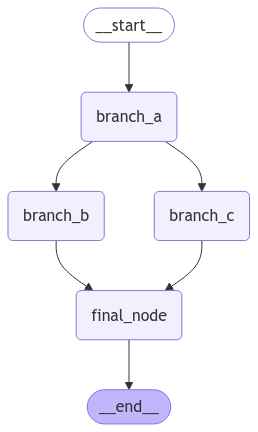

In [3]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [ ]:
runnable.invoke("a") # it starts with a single 'a' and then add another 'a' in branch_b,c and final_node - total if 5 as

[HumanMessage(content='aaaaa', additional_kwargs={}, response_metadata={}, id='91d60310-f0b4-4595-9f08-1246c18bb964')]

## Conditional Edges

In LangGraph, conditional edges allow dynamic decision-making within a graph based on specific conditions or criteria. Instead of processing all edges indiscriminately, conditional edges enable the graph to route messages selectively to the next node(s) depending on the evaluation of conditions.

- The condition is typically a function that evaluates the message or output of a node and determines the path to take.
- Each conditional edge is associated with a function that evaluates a boolean condition.

In [25]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

# Define the entry function for the graph
def entry(input: list[HumanMessage]):
    """
    Entry point for the graph.
    Simply returns the input as-is to be routed further.
    """
    return input

# Define a function for branch B
def work_with_b(input: list[HumanMessage]):
    """
    Processes the input if branch B is selected.
    Prints a message indicating that branch B is being used.
    """
    print("Using branch B")
    return input

# Define a function for branch C
def work_with_c(input: list[HumanMessage]):
    """
    Processes the input if branch C is selected.
    Prints a message indicating that branch C is being used.
    """
    print("Using branch C")
    return input

# Define a routing function to determine which branch to take
def router(input: list[HumanMessage]):
    """
    Determines the next branch based on the content of the input message.
    Routes to "branch_b" if "use_b" is in the message content; otherwise, routes to "branch_c".
    """
    if "use_b" in input[0].content:  # Check for specific keyword in message content
        return "branch_b"
    else:
        return "branch_c"

graph = MessageGraph()

graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "branch_a", router, {"branch_b": "branch_b", "branch_c": "branch_c"}
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

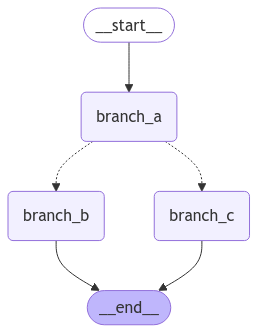

In [ ]:
display(Image(runnable.get_graph().draw_mermaid_png())) # dash line for conditional edge

In [ ]:
runnable.invoke("hello") # nothing was specified

Using branch C


[HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='b810b249-013b-473a-852a-e6ac6d70993f')]

In [ ]:
runnable.invoke("I want to use_b") # specific keyword in the context

Using branch B


[HumanMessage(content='I want to use_b', additional_kwargs={}, response_metadata={}, id='c876a8a3-5586-4ef3-9295-c181b226de7d')]

## Cycles

A cycle in a graph occurs when a node can be revisited by following a path of edges starting from that node. Cycles can occur in both directed and undirected graphs, with specific considerations for each type.

In [32]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

# Initialize a language model with a fixed temperature
model = ChatOpenAI(temperature=0)

# Entry point function for the workflow
def entry(input: list[HumanMessage]):
    # Simply passes the input messages as-is to the next node
    return input

# Action function to process input messages
def action(input: list[HumanMessage]):
    # Prints the current input messages' content
    print("Action taken:", [msg.content for msg in input])
    # Checks if the message count exceeds 5
    if len(input) > 5:
        # Adds a message indicating the end of the process
        input.append(HumanMessage(content="end"))
    else:
        # Adds a message indicating the process should continue
        input.append(HumanMessage(content="continue"))
    return input

# Conditional function to determine the next step in the workflow
def should_continue(input: list):
    # Checks the content of the last message
    last_message = input[-1]
    # If the last message contains "end", return the "__end__" signal to terminate the workflow
    if "end" in last_message.content:
        return "__end__"
    # Otherwise, return the "action" node to continue processing
    return "action"

graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent", should_continue, {"action": "action", "__end__": END}
)
graph.add_edge("action", "agent")

graph.set_entry_point("agent")

runnable = graph.compile()

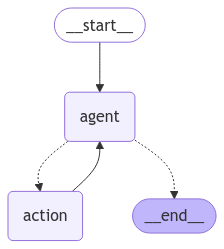

In [10]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [ ]:
runnable.invoke("Hello") # 5 times until get 'end' i the last function should_continue

Action taken: ['Hello']
Action taken: ['Hello', 'continue']
Action taken: ['Hello', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue', 'continue']


[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='421cbced-9187-4745-965a-2898d06c26a0'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='26c4806b-6a9b-4894-a007-037c9e4e85a5'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='d5888293-4e95-4460-b83f-1f9a097ec08e'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='bc595967-21b3-4c92-96d2-8f65004f7cdd'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='4333a602-dd06-4fed-9b62-7b8e532473e1'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='63a80359-a33e-4dfc-9509-87d292bf3ef4'),
 HumanMessage(content='end', additional_kwargs={}, response_metadata={}, id='8eb054fc-23f6-4401-995e-a1b84a79f132')]

## Real Agent - Creating an Agent that actually does something:

In [ ]:
from langchain_openai import ChatOpenAI

# Initialize the model with temperature set to 0 for deterministic output
model = ChatOpenAI(temperature=0)

In [ ]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

# Define the structure of the agent state, including a list of messages and a counter for API calls
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add] # Sequence of messages, supporting addition
    api_call_count: int = 0 # Initialize API call count to 0

In [ ]:
from langchain_core.tools import tool
import random

# Define a tool function that simulates checking the weather in a specified city
@tool
def fake_weather_api(city: str) -> str:
    """Check the weather in a specified city. The API is available randomly, approximately every third call."""

    # Simulate a chance-based response: 1 in 3 calls will succeed
    if random.randint(1, 3) == 1:  # Approximately one-third chance
        return "Sunny, 22°C"
    else:
        return "Service temporarily unavailable"

In [ ]:
# Test the fake weather API for multiple cities
print(fake_weather_api("New York"))
print(fake_weather_api("London")) 
print(fake_weather_api("Berlin"))
print(fake_weather_api("Curitiba"))

Service temporarily unavailable
Sunny, 22°C
Sunny, 22°C
Sunny, 22°C


In [ ]:
# Bind the tool (fake_weather_api) to the model
llm_with_tools = model.bind_tools([fake_weather_api])

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage

# Define a tool mapping for the registered tools
tool_mapping = {"fake_weather_api": fake_weather_api}

# Initialize messages with a human query about the weather
messages = [
    HumanMessage(
        "How will the weather be in munich today? I would like to eat outside if possible"
    )
]

# Invoke the LLM model with the tools and capture the output
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)# Append the LLM's response to the messages list
print(messages)

[HumanMessage(content='How will the weather be in munich today? I would like to eat outside if possible', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lN0yOFXMXSz9algkHZ1v4gYA', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 76, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-96c399ad-a9bd-40fe-b770-05af047ebdc0-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Munich'}, 'id': 'call_lN0yOFXMXSz9algkHZ1v4gYA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 

In [ ]:
# Iterate over each tool call in the LLMs output to simulate executing the tool and appending its response
for tool_call in llm_output.tool_calls:
    # Retrieve the tool from the mapping and invoke it with the provided arguments
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

# Re-invoke the model with the updated messages (after tool output)
llm_with_tools.invoke(messages)

AIMessage(content='The weather in Munich today is sunny with a temperature of 22°C. It looks like a great day to eat outside! Enjoy your meal!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 108, 'total_tokens': 138, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-de4f8bac-bc49-4c2c-b693-b654fa42e51b-0', usage_metadata={'input_tokens': 108, 'output_tokens': 30, 'total_tokens': 138, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
# Define the conditional function to determine if the agent should continue or end
def should_continue(state: AgentState):
    print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    # If there are no tool calls in the last message, the process should end
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

# Define the function to invoke the model with the current state and return updated state
def call_model(state: AgentState):
    messages = state["messages"]
    # Invoke the model with the messages and return the response as the new messages
    response = llm_with_tools.invoke(messages)
    return {"messages": [response], "api_call_count": state["api_call_count"]}

# Define the function to invoke the tool based on the last message's tool call
def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]  # Assume there is at least one tool call
    tool = tool_mapping[tool_call["name"].lower()]  # Get the tool from the mapping
    tool_output = tool.invoke(tool_call["args"])  # Invoke the tool with the arguments
    state["api_call_count"] += 1  # Increment the API call counter
    print("Tool output:", tool_output)
    print("API call count after this tool call:", state["api_call_count"])
    # Create a ToolMessage to store the tool's output and return the updated state
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "api_call_count": state["api_call_count"]}


In [ ]:
from langgraph.graph import StateGraph, END

# Initialize a StateGraph to model the agent's workflow, passing the state schema (AgentState)
workflow = StateGraph(AgentState)

# Add nodes for calling the model and calling the tool (actions performed in the workflow)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the initial entry point of the workflow to the "agent" node
workflow.set_entry_point("agent")

# Add conditional edges to define the next steps: either continue with the tool or end the workflow
workflow.add_conditional_edges(
    "agent",              # From "agent" node
    should_continue,      # Conditional function to evaluate if the agent should continue or end
    {
        "continue": "action",  # If should_continue returns "continue", go to the "action" node
        "end": END,            # If should_continue returns "end", terminate the workflow
    },
)

# Add an edge from the "action" node back to the "agent" node to allow repeated actions
workflow.add_edge("action", "agent")

# Set the entry point again to ensure it starts from the "agent" node
workflow.set_entry_point("agent")

# Compile the workflow into a runnable app
app = workflow.compile()

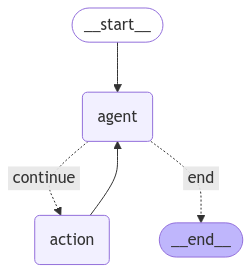

In [21]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [ ]:
from langchain_core.messages import SystemMessage

# Create a system message that sets the context for the agent's behavior
# The system message tells the agent that it is responsible for answering user questions 
# and should use tools for that purpose, even if the tools sometimes fail.
system_message = SystemMessage(
    content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again"
)
# Create a human message where the user is asking about the weather in Munich
human_message = HumanMessage(content="How is the weather in munich today?")
# Combine both system and human messages into a list, which will serve as the input to the agent
messages = [system_message, human_message]

# Invoke the app (which represents the workflow we previously compiled), passing the messages and an initial api_call_count of 0
# The app processes these messages and keeps track of the API call count in the state
result = app.invoke({"messages": messages, "api_call_count": 0})

STATE: {'messages': [SystemMessage(content='You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again', additional_kwargs={}, response_metadata={}), HumanMessage(content='How is the weather in munich today?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uXWxGNCCKYsvnJpyT85x2Q9F', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 95, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-623a5b55-af2

In [ ]:
# Print the content of the last message in the result, which should be the agent's response to the user's query
print(result["messages"][-1].content)

# Print the total API call count after processing the messages
# This will give us the number of times the tools (such as the weather API) were invoked
print(result["api_call_count"])

The weather in Munich today is sunny with a temperature of 22°C.
2
